In [1]:
# How to finetune a transformer for question answering.

In [2]:
# We will be using the Squad Dataset

In [3]:
from datasets import load_dataset
raw_dataset = load_dataset('squad')
raw_dataset
# we can have multiple answers on the same question

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset squad downloaded and prepared to C:/Users/karan/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [4]:
# we won't be using the title filed, but we will be making use of the id column

In [5]:
raw_dataset['train'].filter(lambda x:len(x['answers']['text'])!=1)
# ok so basically we hvae only 1 answer in the training set

Filter:   0%|          | 0/87599 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 0
})

In [6]:
raw_dataset['validation'].filter(lambda x:len(x['answers']['text'])!=1)
# but for validation data we have multiple naswers for the same question this will be problem when we 
# need to complute the metrics

Filter:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 10567
})

In [7]:
raw_dataset['validation']['answers'][2]
# like this it has 3 answers

{'text': ['Santa Clara, California',
  "Levi's Stadium",
  "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."],
 'answer_start': [403, 355, 355]}

In [9]:
from transformers import AutoTokenizer
checkpoint ='distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [10]:
# here we can see that the context can be very long and we need to answer the wuestion based of the context and we can't 
# truncate and as the bert based tokenizer will tokenize the data based of the context length in the bert model
# therefore in order to tokenize the larger context we need to split the context in multiple windows.
# but when we split the data in multiple windows there may be a case in which the end of one window 
# results in some loss of data and we are not able to answer the question as the answer might be cut off, as it was in the 
# boundry.
# Instead of this we allow context windows to overlap['stride'], so than no data is bieng missed.

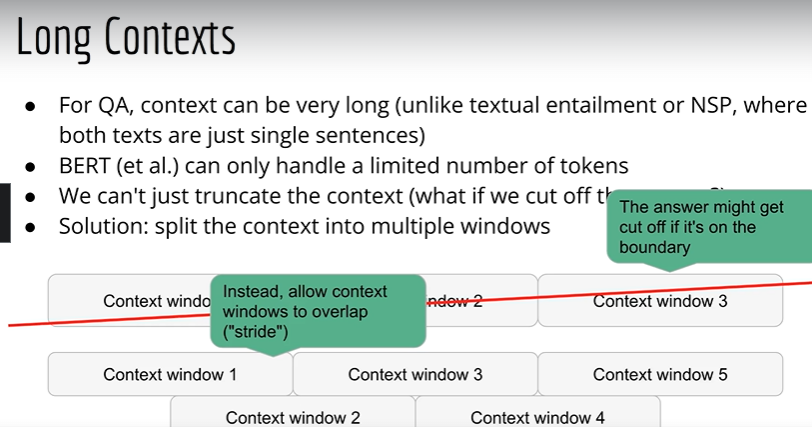

In [11]:
# exampe of what we will do with the tokenizer object 
context = raw_dataset['train']['context'][1]
question = raw_dataset['train']['question'][1]

In [12]:
inputs= tokenizer(question,context)

In [13]:
tokenizer.decode(inputs['input_ids']) # we are combining the question with the given 
# context so as to tokenize them altogether 

'[CLS] What is in front of the Notre Dame Main Building? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive ( and in a direct line that connects through 3 statues and the Gold Dome ), is a simple, modern stone statue of Mary. [SEP]'

In [28]:
# there can be times where the context can be long and so long that we may need to split it up into multiple samples
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation='only_second', # here it means that the context part will be the one which get truncated not the question part
    stride=50,# how much we want the conetxt window to conatin the data from the previous splitted sample
    # as we donot want the answer to be the middle of two windows.
    return_overflowing_tokens=True,
    # this allow the tokenizer to return all the context windows it generated.
)

In [29]:
for ids in inputs['input_ids']:
    print(tokenizer.decode(ids))
# here we can see the overlapping 

[CLS] What is in front of the Notre Dame Main Building? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the G [SEP]
[CLS] What is in front of the Notre Dame Main Building? [SEP] facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernade [SEP]
[CLS] What is in front of the Notre Dame Main Building? [SEP] of the Sacred Heart. Immediately behind the basilica is the Grotto, 

In [24]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'overflow_to_sample_mapping'])

In [30]:
inputs['overflow_to_sample_mapping']
# ok it basically tells us given a lot of different data in abatch altogtehr which data 
# belongs to which id, so that we know that like above there 4 parts for only sample, well 
# this tells us all these above belong to the 1st sample only 

[0, 0, 0, 0]

In [31]:
inputs=tokenizer(
    raw_dataset['train']['question'][:3],
    raw_dataset['train']['context'][:3],
    max_length=100,
    truncation='only_second',
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    # this will basically tell us the space taken by each word between the CLS and 
    # SEP token we can also get the location given these corrdinates and the 
    # the text representation, whereas the cls and sep token will always have 0,0 values as they 
    # they take up 0 space.
    # usually each paragraph would be 100 tokens long but we may get less tokens as well in the ending paragraphs 
)

In [32]:
for ids in inputs['input_ids']:
    print(tokenizer.decode(ids))

[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basi [SEP]
[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin [SEP]
[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Next to the Main Building is the B

In [33]:
inputs['overflow_to_sample_mapping']
# using this we can map the above splits of data basically telling us that the context at the id 0 is bieng splitted up into 
# 4 parts and so on for the other data 

[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2]

In [57]:
len(inputs['offset_mapping'][3]) # we have less tokens in the ending paragraph

85

In [53]:
# Aligning the Targets 
# the problem that we are facing now is that the answer may be any of the batch that we have 
# created and the position of the answer according to than batch we know but what about the fact that 
# the answer posotion in the original context is still unknow therefore we nned too align 
# those answers as well.

In [114]:
# we are thinking of neural network as a classification task of picking the correct time step in order to get the correct ans.
# so in order to predcit the target we will treat this as a classification task. 
# The first outputs might predcit the start token whereas the second T outputs will predcit the end token of the answer 
# rememebr that we have timesteps of each of the words in the data given 
inputs.sequence_ids(0)# it basically tells us where to focus on the words 

[None,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 None,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 None]

In [115]:
ctx_start = inputs.sequence_ids(0).index(1)

In [116]:
ctx_start# first one starts at the 17 index

17

In [117]:
ctx_end = len(inputs.sequence_ids(0))-inputs.sequence_ids(0)[::-1].index(1)-1 # basically -2 from each of the conetxt give you the 
# position hwere you need to focus on.

In [118]:
ctx_end

98

In [119]:
# Given all of these data we need to focus on the part that where the context end or starts we can do this by making use of the offset mapping
# and the index position that we can get from above. Looking donw in the picture below will make you understand it much more clearly.

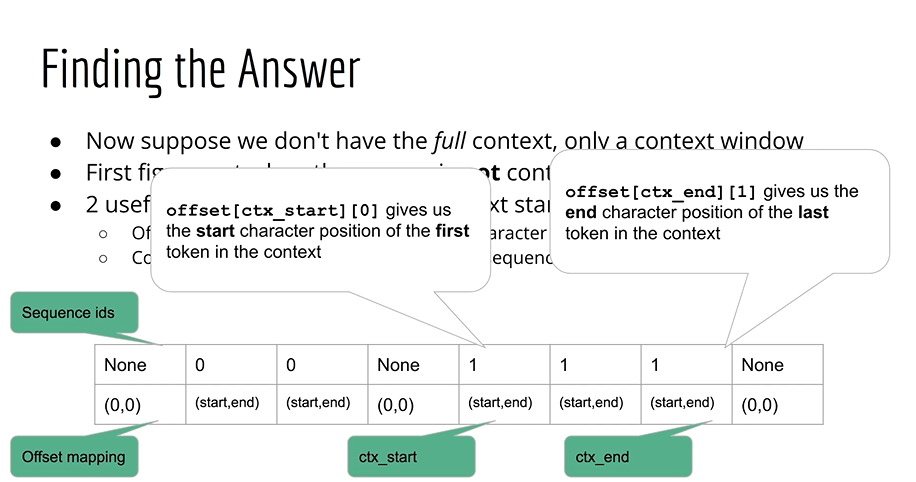

In [94]:
# In summary we are gtting the start character of the word in the given index and the end character of ending sequence therefore 
# we just need to map the answers now to these index's by checking these against the answer start index and the answer end index.
# But we still have a problem as to if the answer is in mutiple context windows how do we take care of that.
# we will in this case tells that the answer don't exist whereas when the answer is contained within the context window.

In [95]:
# we want tio find the token position of the answer related to the current conetxt window and not the full context.

In [96]:
# given all this new information we need to deal with indices of tokens and indices of characters, if we look abaove we 
# are dealing with the starting and ending indexs of the words as well
# for neural network target we want to find the token start/end indices

In [97]:
# but in the dataset we are getting the naswer in terms of character indices, for this we need to convert the character index to token 
# index

In [150]:
answer = raw_dataset['train']['answers'][0]

In [151]:
answer # we need to map this answer in the conetxt window based.
# but there can be a problem as the answer will change in each window of the context, and the answer is also the target for the 
# neural network, so there is a problem of recomputing the targets from each of the context window.

{'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}

In [152]:
type(inputs.sequence_ids(0))

list

In [153]:
# Above we know how to calculate the last and the forst index so as to kjnow the tokens where we have to put our focus on

In [154]:
# we also have to check whether the answer is fully contained within the context or not, if not then the traget would be (0,0)
# mapping to (start_idx,end_idx)
ans_start_char = answer['answer_start'][0] # we get like 188 in this 
# we also need the answer end for this 
ans_end_char = ans_start_char + len(answer['text'][0]) # we get like the ending of teh inde as well

In [155]:
inputs['offset_mapping'][0] # the good thing about this offset mapping is that we will have the entire context data to be taken into 
# account as it will give the same index coordinates to each word accordingly.
# so basically we are going to look for start and end index in this list from the point where we have to focus in and then 
# find out in our cotext windows, does there exist the complete answer or not 

[(0, 0),
 (0, 2),
 (3, 7),
 (8, 11),
 (12, 15),
 (16, 22),
 (23, 27),
 (28, 37),
 (38, 44),
 (45, 47),
 (48, 52),
 (53, 55),
 (56, 59),
 (59, 63),
 (64, 70),
 (70, 71),
 (0, 0),
 (0, 13),
 (13, 15),
 (15, 16),
 (17, 20),
 (21, 27),
 (28, 31),
 (32, 33),
 (34, 42),
 (43, 52),
 (52, 53),
 (54, 56),
 (56, 58),
 (59, 62),
 (63, 67),
 (68, 76),
 (76, 77),
 (77, 78),
 (79, 83),
 (84, 88),
 (89, 91),
 (92, 93),
 (94, 100),
 (101, 107),
 (108, 110),
 (111, 114),
 (115, 121),
 (122, 126),
 (126, 127),
 (128, 139),
 (140, 142),
 (143, 148),
 (149, 151),
 (152, 155),
 (156, 160),
 (161, 169),
 (170, 173),
 (174, 180),
 (181, 183),
 (183, 184),
 (185, 187),
 (188, 189),
 (190, 196),
 (197, 203),
 (204, 206),
 (207, 213),
 (214, 218),
 (219, 223),
 (224, 226),
 (226, 229),
 (229, 232),
 (233, 237),
 (238, 241),
 (242, 248),
 (249, 250),
 (250, 251),
 (251, 254),
 (254, 256),
 (257, 259),
 (260, 262),
 (263, 264),
 (264, 265),
 (265, 268),
 (268, 269),
 (269, 270),
 (271, 275),
 (276, 278),
 (279, 2

In [156]:
inputs['offset_mapping'][1]

[(0, 0),
 (0, 2),
 (3, 7),
 (8, 11),
 (12, 15),
 (16, 22),
 (23, 27),
 (28, 37),
 (38, 44),
 (45, 47),
 (48, 52),
 (53, 55),
 (56, 59),
 (59, 63),
 (64, 70),
 (70, 71),
 (0, 0),
 (152, 155),
 (156, 160),
 (161, 169),
 (170, 173),
 (174, 180),
 (181, 183),
 (183, 184),
 (185, 187),
 (188, 189),
 (190, 196),
 (197, 203),
 (204, 206),
 (207, 213),
 (214, 218),
 (219, 223),
 (224, 226),
 (226, 229),
 (229, 232),
 (233, 237),
 (238, 241),
 (242, 248),
 (249, 250),
 (250, 251),
 (251, 254),
 (254, 256),
 (257, 259),
 (260, 262),
 (263, 264),
 (264, 265),
 (265, 268),
 (268, 269),
 (269, 270),
 (271, 275),
 (276, 278),
 (279, 282),
 (283, 287),
 (288, 296),
 (297, 299),
 (300, 303),
 (304, 312),
 (313, 315),
 (316, 319),
 (320, 326),
 (327, 332),
 (332, 333),
 (334, 345),
 (346, 352),
 (353, 356),
 (357, 358),
 (358, 361),
 (361, 365),
 (366, 368),
 (369, 372),
 (373, 374),
 (374, 377),
 (377, 379),
 (379, 380),
 (381, 382),
 (383, 389),
 (390, 395),
 (396, 398),
 (399, 405),
 (406, 409),
 (4

In [162]:
start_idx=0
end_idx=0
# we set them this way when we see that no 
if inputs['offset_mapping'][2][ctx_start][0] > ans_start_char or inputs['offset_mapping'][2][ctx_end][1]< ans_end_char:
    # means that the answer is not in that context window and we can assign this as target(0,0).
    print("target(0,0)")
else:
    i= ctx_start
    for a in inputs['offset_mapping'][2][ctx_start:]:
        start,end = a 
        if start == ans_start_char:
            start_idx=i 
        if end == ans_end_char:
            end_idx=i 
            break
        i+=1       

In [163]:
start_idx,end_idx # now we need the words in the start index and end index

(72, 78)

In [168]:
tokenizer.decode(inputs['input_ids'][2][start_idx:end_idx+1])
# here we get the complete ans, and we are able to map the index's

'Saint Bernadette Soubirous'

In [169]:
answer

{'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}

In [170]:
# and we see that it matches with our answer.

In [218]:
def find_answer_token_idx(ctx_start,ctx_end,ans_start_char,ans_end_char,offset):
    start_idx=0
    end_idx=0
    if offset[ctx_start][0] > ans_start_char or offset[ctx_end][1]< ans_end_char:
        pass
    else:
        i= ctx_start
        for a in offset[ctx_start:]:
            start,end = a 
            if start == ans_start_char:
                start_idx=i 
            if end == ans_end_char:
                end_idx=i 
                break
            i+=1
    return start_idx,end_idx  
# using this we can do what we did for all the input sentences than just once 

In [219]:
start_idxs =[]
end_idxs=[]
for i, offset in enumerate(inputs['offset_mapping']):# will have the contextswindows for each context and the 
    # list of tuple's in each of the windows where we only need the one with the sequence id's as 1 ti get the answer 
    # as the one with sequence id's 0 will have the questions in them 
    sequence_ids = inputs.sequence_ids(i)
    ctx_start=sequence_ids.index(1)
    ctx_end=len(sequence_ids) -2 # it;s the same
    x = find_answer_token_idx(ctx_start,ctx_end,ans_start_char,ans_end_char,offset)
    if x is None:
        pass
    else:
        start_idxs.append(x[0])
        end_idxs.append(x[1])

In [198]:
tokenizer.decode(inputs['input_ids'][11][x[0]:x[1]+1]) 

'Saint Bernadette Soubirous'

In [188]:
x

(40, 46)

In [199]:
tokenizer.decode(inputs['input_ids'][11]) 

'[CLS] The Basilica of the Sacred heart at Notre Dame is beside to which structure? [SEP]. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive ( and in a direct line that connects through 3 statues and the Gold Dome ), is a simple, modern stone statue of Mary. [SEP]'

In [216]:
inputs['input_ids'][11][40]

2216

In [217]:
tokenizer.decode(2216)

'Saint'

In [209]:
# There for our function is working 

In [220]:
start_idxs # we are gtiing six values as our answer is in start index are only in 6 
# of the 12 context values. and we hvae 0's for the valued where there is no answer presengt

[0, 0, 72, 40, 0, 0, 60, 24, 0, 0, 72, 40]

In [221]:
end_idxs

[0, 0, 78, 46, 0, 0, 66, 30, 0, 0, 78, 46]

In [222]:
# Now all of these preprocessing comes under the play of tokenzie functions and w ebasically have to calculate the 
# start and the ending index's
# we have seen in the dataset that some of the questions and leading or trailing white spaces 
# so we will get rid of that 

In [339]:
max_length =384 
stride = 128
# these are teh same parameters that are being used by google.
def tokenize_fn_train(batch):# we will do train and validation seprate as in validation 
    # there are two answers also for some questions as shown above
    # removing the white spaces from the questions
    questions = [q.strip() for q in batch['question']]
    answers= batch['answers']
    inputs = tokenizer(
        questions,
        batch['context'],
        max_length=max_length,
        truncation = 'only_second',
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding='max_length', # padding all the sequences to max length 
    )
    offset_mapping = inputs.pop('offset_mapping')
    orig_sample_idxs= inputs.pop('overflow_to_sample_mapping')
    start_idxs,end_idxs =[],[] 
    for i, offset in enumerate(offset_mapping):
        sample_idx=orig_sample_idxs[i] # we are grabbing the context splitted data
        answer = answers[sample_idx] # Here we are grabbing the answer based of the splitted 
        # context integers 
        ans_start_char= answer['answer_start'][0]
        ans_end_char= len(answer['text'][0])+ans_start_char
        sequence_ids = inputs.sequence_ids(i) 
        ctx_start = sequence_ids.index(1)
        ctx_end = len(sequence_ids)-2 
        start_idx,end_idx = find_answer_token_idx(ctx_start,ctx_end,ans_start_char,ans_end_char,offset)
        start_idxs.append(start_idx)
        end_idxs.append(end_idx)
    inputs['start_positions']= start_idxs
    inputs['end_positions']=end_idxs # WE NEED TO BE VERY CAREFULL ABOUT THESE NAMES
    return inputs   
def tokenize_fn_validation(batch):
    questions = [q.strip() for q in batch['question']]
    answers= batch['answers']
    inputs = tokenizer(
        questions,
        batch['context'],
        max_length=max_length,
        truncation = 'only_second',
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding='max_length', # padding all the sequences to max length 
    )
    orig_sample_idxs = inputs.pop('overflow_to_sample_mapping')
    # we donot need offset here as in compute metrics 
    # we will check the answers in the character format
    sample_ids =[]
    for i in range(len(inputs['input_ids'])): # the input IDs are basically cintext split up tokenized numeric format
        sample_idx=orig_sample_idxs[i]
        sample_ids.append(batch['id'][sample_idx]) # in the validation dataset we also have a unique id associated with each context
        sequence_ids=inputs.sequence_ids(i) # have 0's in the position which corrsponds to the text whereas hvae 1 in the position
        # which corresponds to context 
        # Now we want to replace all the question based start,end offset mappings to be None.
        offset = inputs['offset_mapping'][i]
        inputs['offset_mapping'][i] = [x if sequence_ids[j] == 1 else None for j,x in enumerate(offset)]
        # This entire thing is explained below in the image 
    inputs['sample_id']=sample_ids
    return inputs

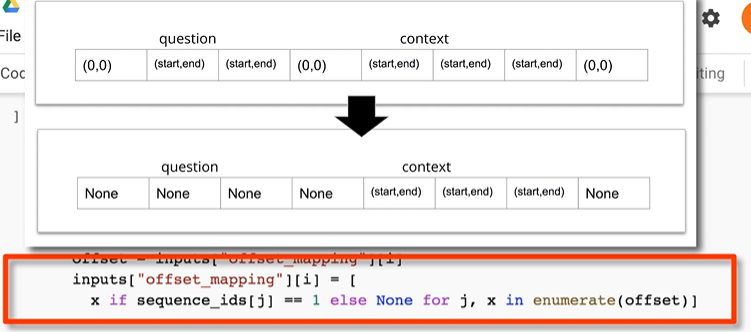 

In [340]:
train_dataset = raw_dataset['train'].map(
    tokenize_fn_train,batched=True,remove_columns=raw_dataset['train'].column_names,
)
validation_dataset =raw_dataset['validation'].map(
    tokenize_fn_validation, batched=True,remove_columns=raw_dataset['validation'].column_names,
)

Loading cached processed dataset at C:\Users\karan\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-8da20d3c66d1f1ce.arrow
Loading cached processed dataset at C:\Users\karan\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-11299f474cb96cd5.arrow


In [335]:
train_dataset # we have different size from their original set because there might be some context windows where there was 
# extra samples were created

Dataset({
    features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 88729
})

In [361]:
validation_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'offset_mapping', 'sample_id'],
    num_rows: 10822
})

In [235]:
from datasets import load_metric

In [238]:
metric= load_metric('squad')
# predefined metric available in the HUgging face 
# High lvl intution, metric make use of teh actual strings to compare the answers, we will have 2 parameters exact_match and 
# f1 which gives you score evn if you are having a particla correct answer but exact match is some what similar to the accuracy and 
# we get the score to as how much of the answers are exactly equal.
# Metric also takes into account the fact that we have more answers to the same question

In [242]:
# Form in which the answers are computed 
predicted_answers = [
    {'id':'1','prediction_text':'albert einstein'},
    {'id':'2','prediction_text':'physicist'}
]
true_answers = [
    {'id':'1','answers':{'text':['Albert Ein'],'answer_start':[100]}},
    {'id':'2','answers':{'text':['Physicist'],'answer_start':[100]}}
]

metric.compute(predictions=predicted_answers,references=true_answers)
# teh keys need to be same 
# we see that the exact macth is for 1 and we see that the f1 is giving out accuracy even if we have the answer that is partially correct


{'exact_match': 50.0, 'f1': 75.0}

##### LOGITS TO ANSWERS

In [243]:
# In oder to know how to compute the logits to answers first we are going to convert the predicted answers from a pretrained models to 
# logits and then convert them back so as to apply them in our own model.

In [244]:
small_validation_dataset = raw_dataset['validation'].select(range(1000))

In [246]:
trained_checkpoint ='distilbert-base-cased-distilled-squad'
tokenizer2 = AutoTokenizer.from_pretrained(trained_checkpoint)
old_tokenizer = tokenizer
tokenizer = tokenizer2
small_validation_processed = small_validation_dataset.map(tokenize_fn_validation,batched=True,remove_columns=raw_dataset['validation'].column_names)
tokenizer=old_tokenizer

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [249]:
from transformers import AutoModelForQuestionAnswering 
import torch 

In [248]:
small_validation_processed

Dataset({
    features: ['input_ids', 'attention_mask', 'offset_mapping', 'sample_id'],
    num_rows: 1025
})

In [254]:
# The trained model that we will be making use of will not have sample_id and offset mapping in it but we have those in our dataset 
# due to our predefined tokezied function
small_model_inputs = small_validation_processed.remove_columns(['sample_id','offset_mapping'])
small_model_inputs.set_format('torch') 

In [251]:
trained_model = AutoModelForQuestionAnswering.from_pretrained(trained_checkpoint)

In [258]:
with torch.no_grad(): # because we donot want graidents to be computed
    outputs = trained_model(**{k: small_model_inputs[k] for k in small_model_inputs.column_names})# this just gives us all the values in the 
    # small model that are basiclly the input ids and attention mask
    # we are just mapping the input ods and attention mask values with the trained models in order to get the logits 

In [259]:
small_model_inputs

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 1025
})

In [261]:
outputs # This give us the start logist and end logits 

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[ -2.2607,  -5.1783,  -5.2709,  ...,  -9.5243,  -9.5183,  -9.5288],
        [ -2.5961,  -5.5482,  -5.5313,  ...,  -9.9598,  -9.9533,  -9.9860],
        [ -3.7127,  -7.1848,  -8.5388,  ..., -11.6557, -11.6571, -11.6505],
        ...,
        [ -2.2693,  -3.4890,  -5.0115,  ...,  -8.4847,  -8.4810,  -8.4723],
        [ -2.9487,  -4.6808,  -5.1576,  ...,  -8.7147,  -8.7635,  -8.7136],
        [ -2.3916,  -3.9164,  -4.7689,  ...,  -8.9350,  -8.9489,  -8.8685]]), end_logits=tensor([[-7.3526e-01, -4.9236e+00, -5.1048e+00,  ..., -8.8734e+00,
         -8.8915e+00, -8.8550e+00],
        [-1.3056e+00, -5.3870e+00, -5.4945e+00,  ..., -9.4895e+00,
         -9.5039e+00, -9.4958e+00],
        [-2.7649e+00, -7.2201e+00, -9.0916e+00,  ..., -1.1311e+01,
         -1.1341e+01, -1.1270e+01],
        ...,
        [-9.6721e-03, -2.8000e+00, -4.0942e+00,  ..., -7.6105e+00,
         -7.6059e+00, -7.5000e+00],
        [-9.7628e-01, -5.3496e+00, -4.26

In [263]:
len(outputs[0])# this is equal to the number of samples we have, but if we look closely we have 25 more values than what we 
# started with AS WE ONLY SUPPLIED 1000, we have more because of the fcat that we may habe overlapping context have the answers in them


1025

In [264]:
len(outputs[0][0]) # this is basically eaqua to each sample size that we have, so basically we are having numeric values assigned with 
# each of the token that we have 

384

In [265]:
start_logits  = outputs.start_logits.cpu().numpy()

In [266]:
end_logits = outputs.end_logits.cpu().numpy()

In [270]:
small_validation_processed['sample_id'][:5]  # example of th eunizque ID's

['56be4db0acb8001400a502ec',
 '56be4db0acb8001400a502ed',
 '56be4db0acb8001400a502ee',
 '56be4db0acb8001400a502ef',
 '56be4db0acb8001400a502f0']

### Mapping Sample Id's to Dataset_Index 

In [271]:
# Example {'56be4db0acb8001400a502ec' :[0,1,2,3] ......}
sample_id2idxs ={}
for i,id_ in enumerate(small_validation_processed['sample_id']):
    if id_ in sample_id2idxs:
        sample_id2idxs[id_].append(i) 
    else:
        sample_id2idxs[id_] = [i]
# we are doig this to keep in track of the context windows where we have answers in 2 or more conetxt windows for the single sample

In [272]:
# IN the end and Start logits that we have obtained so far we will know that in the context the higher value will be given to start 
# and end logits of the values in the context therefore by taking a product of them, we will find the best score and can get the 
# the end and start best logit values index's, we can see that in the image below.

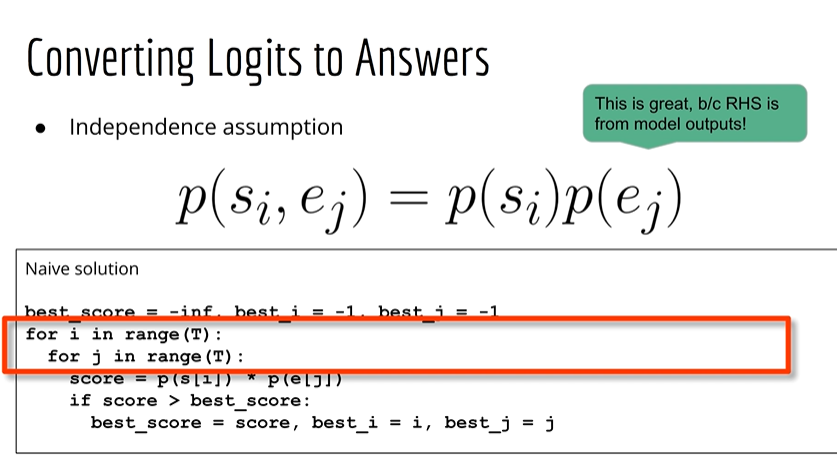

In [273]:
# The problem with this approach is that the T values will be 384 and we will be having 384*384 iterations for each sample
# which is a lot of computation so we need to apply some method to reduce this computation.
# we cannot just take the maximum probabilities for this, but we need to take atleast 20 best of both 
# start and end logits.
# We consider 3 cases where we will account for invalid answers, 
# case 1 is i or j is outside context
# case2 is i>j
# case 3 is when the answer is too long so we just simply cutoff at 30 tokens.

In [ ]:
# instead of multiplcation  we will be doing additions by taking log of the probablities and we know that 
# id A>B then log(A)>log(B) 
# INstead of probabilities we can make use of argmaxlog(si) + log(ej) which we have shown below

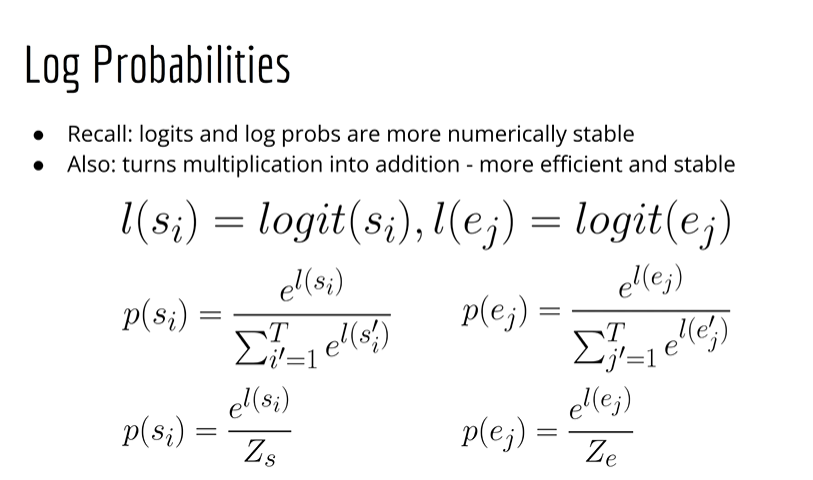


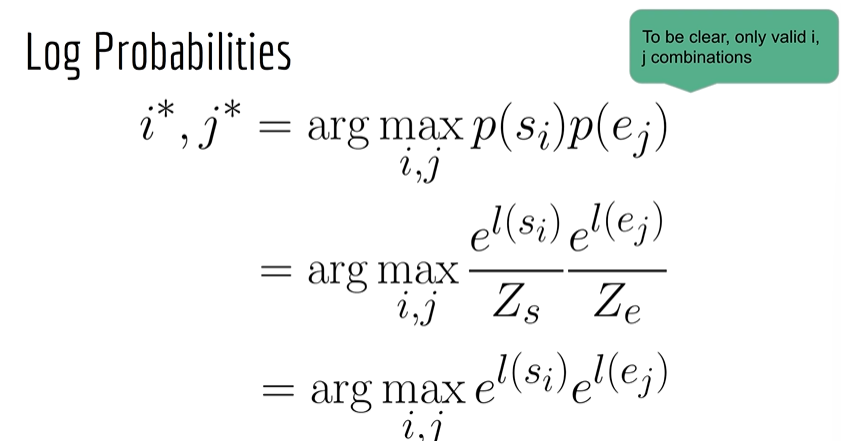

### We can rempve Zs and Ze as it doesn't matter are simply constants.

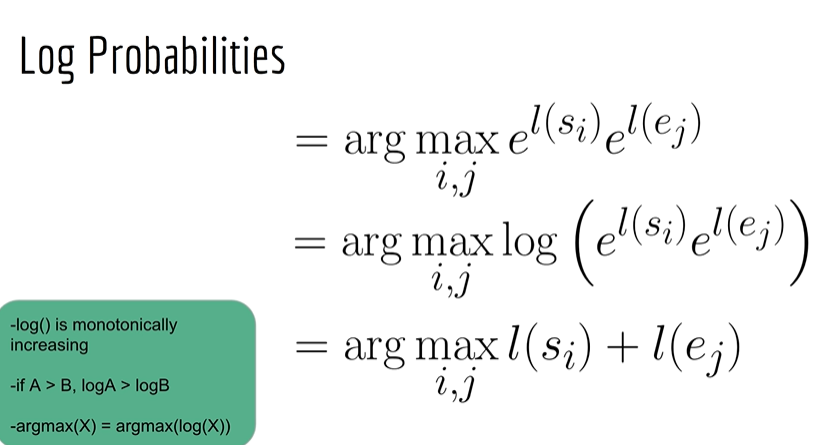

In [297]:
max_answer_length = 30 # we are not considerig answer which are longer than 30 tokens
n_largest = 20 # we will taking in account of 20 largest values of end and start logits 
predicted_answers =[]
for sample in small_validation_dataset:
    sample_id = sample['id'] # just getting all the sample id's as they are unique for 
    # each of the context windows as well
    context = sample['context'] # we are having this as this contains the answer
    best_score=float('-inf')
    best_answer = None
    for idx in sample_id2idxs[sample_id]:# this will ahve all the context windows for the same conetxt 
        # ids withinh it 
        start_logit =start_logits[idx] # getting the start logits of the context window 
        end_logit = end_logits[idx] 
        offsets = small_validation_processed[idx]['offset_mapping'] # this is modified to cointain the value of
        # none
        start_indices =(-start_logit).argsort() # getting the logits in descending order 
        end_indices =(-end_logit).argsort()# this will gives us the index values of the sorted logits 
        for start_idx in start_indices[:n_largest]:
            for end_idx in end_indices[:n_largest]:
                if offsets[start_idx] is None or offsets[end_idx] is None:
                    # we are doing this because there can be a chance that the selected logits we get ay be None
                    continue 
                if end_idx < start_idx:
                    continue # where the ending index is smaller than the starting index which is not
                    # good
                if end_idx -start_idx +1 > max_answer_length: # where answers are too long
                    continue 
                score = start_logit[start_idx]+end_logit[end_idx]
                if score > best_score:
                    best_score=score
                    first_char = offsets[start_idx][0]
                    end_char = offsets[end_idx][1]
                    best_answer=context[first_char:end_char]
                    
    predicted_answers.append({'id':sample_id,'prediction_text':best_answer})

In [291]:
true_answers = [
    {'id':x['id'],'answers':x['answers']} for x in small_validation_dataset
]
# getting all the answers only with sample id for 

In [298]:
metric.compute(predictions=predicted_answers,references=true_answers) 
# Git a good score basically we have the answers as well 

{'exact_match': 83.6, 'f1': 87.6652760421553}

In [299]:
# We need to design a custom based compute metrics because in the models that we will define 
# will basically have a function to compute metrics based on logits and labels, we can do that 
# but in this case we will make use of above methods. 

In [304]:
from tqdm.autonotebook import tqdm

n_largets = 20 

max_answer_length=30

def compute_metrics( 
    start_logits,
    end_logits,
    processed_dataset,# basically the validation dataset 
    original_dataset):
    sample_id2idxs ={}
    
    for i, _id in enumerate(processed_dataset['sample_id']):
        
        if _id not in sample_id2idxs:
            
            sample_id2idxs[_id] =[i] 
        else:
            sample_id2idxs[_id].append(i)
            
    predicted_answers=[]
    
    for sample in tqdm(original_dataset):
        
        sample_id = sample['id']
        context = sample['context'] # we are having this as this contains the answer
        best_score = float('-inf')
        best_answer = None
        
        for idx in sample_id2idxs[sample_id]:
            
            start_logit = start_logits[idx]
            end_logit = end_logits[idx]
            offsets = processed_dataset[idx]['offset_mapping']
            start_indices =(-start_logit).argsort() 
            end_indices =(-end_logit).argsort()
            
            for start_idx in start_indices[:n_largest]:
                for end_idx in end_indices[:n_largest]:
                    
                    if offsets[start_idx] is None or offsets[end_idx] is None:
                    # we are doing this because there can be a chance that the selected logits we get ay be None
                        continue 
                        
                    if end_idx < start_idx:
                        continue # where the ending index is smaller than the starting index which is not
                    # good
                    
                    if end_idx -start_idx +1 > max_answer_length: # where answers are too long
                        continue 
                        
                    score = start_logit[start_idx]+end_logit[end_idx]
                    
                    if score > best_score:
                        
                        best_score=score
                        
                        first_char = offsets[start_idx][0]
                        
                        end_char = offsets[end_idx][1]
                        
                        best_answer=context[first_char:end_char] 
                        
        predicted_answers.append({'id':sample_id,'prediction_text':best_answer})
        
    true_answers = [{'id':x['id'],'answers':x['answers']} for x in small_validation_dataset]
    
    return metric.compute(predictions=predicted_answers,references=true_answers)

In [305]:
compute_metrics(start_logits,end_logits,small_validation_processed,small_validation_dataset)

  0%|          | 0/1000 [00:00<?, ?it/s]

{'exact_match': 83.6, 'f1': 87.6652760421553}

In [315]:
model=AutoModelForQuestionAnswering.from_pretrained('distilbert-base-cased')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForQuestionAnswering: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on

In [316]:
from transformers import TrainingArguments,Trainer

In [317]:
args = TrainingArguments(
'finetuned-squad',evaluation_strategy='no',save_strategy='epoch',learning_rate=2e-5,num_train_epochs=1,weight_decay=0.01)

In [326]:
trainer1 = Trainer(model=model,args = args,train_dataset=train_dataset.shuffle().select(range(1000)),eval_dataset=validation_dataset,tokenizer=tokenizer)

In [327]:
trainer1.train()

C:\Users\karan\.pyenv\pyenv-win\versions\3.11.3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=125, training_loss=1.030083740234375, metrics={'train_runtime': 472.3749, 'train_samples_per_second': 2.117, 'train_steps_per_second': 0.265, 'total_flos': 97989825024000.0, 'train_loss': 1.030083740234375, 'epoch': 1.0})

In [354]:
trainer_output = trainer1.predict(validation_dataset)

In [364]:
predictions,_,_ =trainer_output

In [365]:
start_logits,end_logits = predictions

In [366]:
validation_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'offset_mapping', 'sample_id'],
    num_rows: 10822
})

In [ ]:
compute_metrics(start_logits,end_logits,validation_dataset,raw_dataset['validation']) 

In [368]:
trainer1.save_model('qa')

In [369]:
from transformers import pipeline 
pipe = pipeline('question-answering',model = 'qa')

In [371]:
context ='Today I went to the store to purchase a carton of milk'
question ='what did I buy?'
pipe(context=context,question=question)
# This is not a good prediction as we trained it only in 1000 samples and for only 1 epoch, but it tells us that our pipelienworks fine

{'score': 1.5140359721499408e-07,
 'start': 13,
 'end': 46,
 'answer': 'to the store to purchase a carton'}